# Building a 2D CNN for Image Classification
In this tutorial, we will be learning how to build a 2D version of a Convolutional Nerual Network (CNN).


For this example, we will again be using the same dataset of histological images: http://dx.doi.org/10.5281/zenodo.53169. 

![Example histological images for classes a through f](https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/Images/Week3/Representative-images-the-first-10-images-of-every-tissue-class.png?token=ADGRCSE2YIYWUNCJTHNB5XK67T4HE)

# Imports
Start by importing the packages and modules we will be needing for this project.

In [1]:
# Basic operating system (os), numerical, and plotting functionality
import os
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn data utilities
from sklearn.model_selection import train_test_split
import skimage.transform as image_transform

# scikit-learn performance metric utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Import our neural network building tools
import tensorflow as tf

# Garbage collection (for saving RAM during training)
import gc

# Retrieve and Load the Data
The following cell checks if the histological images have already been downloaded into the current Colab session and downloads them if not.

In [2]:
# Define the current directory and the directory where the files to download can
# be found
current_dir = '/content'
remote_path = 'https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/'

# Define and build a directory to save this data in
data_dir = '/content/crc_data'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

# Move into the data directory and download all of the files
os.chdir(data_dir)
for ii in range(1, 6):
    basename = f'rgb0{ii}.npz'
    filename = os.path.join(remote_path, basename)

    # Check if the file has already been downloaded
    if not os.path.isfile(basename):
      cmd = f'wget {filename}'
      print(cmd)
      os.system(cmd)

# Return to the original directory
os.chdir(current_dir)

wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb01.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb02.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb03.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb04.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb05.npz


The downloaded ".npz" archives can now be read into memory and parsed using our data loading function copied from the previous tutorial.

In [3]:
# Define a function to load the data from the assumed download path
def load_images(colorspace='rgb'):
    """
    Loads the example data and applies transformation into requested colorspace

    Arguments
    ---------
    colorspace : str, optional, default: `rgb`
        The colorspace into which the images should be transformed. Accepted
        values include

        'rgb' : Standard red-green-blue color-space for digital images

        'gray' or 'grey': An arithmetic average of the (r, g, b) values

        'lab': The CIE L* a* b* colorspace
    
    Returns
    -------
    images : numpy.ndarray, shape (Nimg, Ny, Nx, Ncolor)
        The complete set of transformed images

    labels : numpy.ndarray, shape (Nimg)
        The classification labels associated with each entry in `images`

    label_to_str : dict
        A dictionary which converts the numerical classification value in
        `labels` into its string equivalent representation.
    """
    # Check that the colorspace argument is recognized
    colorspace_lower = colorspace.lower()
    if colorspace_lower not in ['rgb', 'gray', 'grey', 'lab']:
        raise ValueError(f'`colorspace` value of {colorspace} not recognized')

    # Load data, which is stored as a numpy archive file (.npz)
    filename = os.path.join(data_dir, 'rgb01.npz')
    print(f'loading {filename}')
    tmp = np.load(os.path.join(data_dir, 'rgb01.npz'), allow_pickle=True)

    # Parse the loaded data into images and labels
    # Initialize the images and labels variables using the first archive data
    images = tmp['rgb_data']
    if colorspace_lower == 'rgb':
        pass
    elif colorspace_lower in ['gray', 'grey']:
        images = np.mean(images, axis=-1)      # Average into grayscale
    elif colorspace_lower == 'lab':
        images = rgb2lab(images)               # Convert to CIE L*a*b*

    # Grab the initial array for the image labels
    labels = tmp['labels']
    
    # Grab the dictionary to convert numerical labels to their string equivalent
    label_to_str = tmp['label_str']
    label_to_str = label_to_str.tolist() # Convert label_to_str into a dict

    # Update the user on the number and size of images loaded
    print('Loaded images with shape {}'.format(images.shape))
    del tmp

    # Loop over each of the remaining archives and append the contained data
    for ii in range(2,6):
        # Build the full path to the archive and load it into memory
        filename = os.path.join(data_dir, f'rgb0{ii}.npz')
        print(f'loading {filename}')
        tmp = np.load(filename, allow_pickle=True)

        # Parse and append the data
        these_images = tmp['rgb_data']
        if colorspace_lower == 'rgb':
            pass
        elif (colorspace_lower == 'gray') or (colorspace_lower == 'grey'):
            these_images = np.mean(these_images, axis=-1) # Convert to grayscale
        elif colorspace_lower == 'lab':
            these_images = rgb2lab(these_images)          # Convert to CIEL*a*b*

        # Append the images and labels
        images = np.append(images, these_images, axis=0)
        labels = np.append(labels, tmp['labels'], axis=0)

        # Update the user on the number and size of images
        print('Loaded images with shape {}'.format(these_images.shape))
        del tmp

    # Force the image data to be floating point and print the data shape
    images = images.astype(np.float)
    print('Final image data shape: {}'.format(images.shape))
    print('Number of image labels: {}'.format(*labels.shape))

    return images, labels, label_to_str

With this data-loading function defined, let's load in the grayscale images.

In [4]:
# Load the data using our data-loading function
#
# You can change the `colorspace` keyword argument in `load_images` function
# call to try to try training classifier an image in another colorspace
images_full_res, labels, label_to_str = load_images(colorspace='gray')
num_classes = np.unique(labels).size

loading /content/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150)
loading /content/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150)
loading /content/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150)
loading /content/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150)
loading /content/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150)
Final image data shape: (5000, 150, 150)
Number of image labels: 5000


## Pre-process the Images

The following cells apply some pre-processing steps to the image data.

### Resize the Images for Faster Training

In the following cell, we resize the images so that they are lower resolution than the originals. This only has a minimal impact on the classifier performance, but it significantly accelerates training.

In [5]:
# Grab the original shape of the images
num_images = images_full_res.shape[0]

# Specify a desired resizing shape.
# NOTE: This can be modified to trade-off between training-speed and performance
resize_shape = (48, 48)

# Initialize an array for storing the resized images
images = np.zeros((num_images,) + resize_shape)

# Loop over each image in the data and perform a resizing operation
for img_num, img_data in enumerate(images_full_res):
    images[img_num] = image_transform.resize(img_data, resize_shape)

# Remove the full-resolution versions from memory (just glogging things up)
del images_full_res

## Normalize the Image Data
All images should be normalized to the range $\left[0, 1\right]$. The procedure for this will depend on the current colorspace of the images, but some basic guidelines follow:

* **RGB and greyscale:** images are often represented with integers in the range $\left[0, 255\right]$, so dividing by $255$ will often normalize these images (if they are not already normalized).

* **HSV, HSI, HSL:** the Hue (H) channel will typically be represnted by a number in the range $\left[0^{\circ}, 360^{\circ}\right)$. The Saturation channel channels will often be represented on a scale from $\left[0, 1\right]$, in which case no normalization is required. The final channel (Value, Intensity, or Lightness) is often represented by a snumber in the range of either $\left[0, 1\right]$ or $\left[0, 100\right]$, so a simple investigation should indicate what normalization may be needed for that channel.

* **CIE L\*a\*b\*:** The L\* channel often has a range of $\left[0, 100\right]$ while the a\* and b\* channels are in the range $\left[-100, +100\right]$. In some cases, the data may be represented by signed 8-bit integers, in which case the range of values is acutally maped to the discrete space from $\left[-128, +127\right]$, so you may need to examine if your data is integer or float.

In [6]:
# In this notebook, we are only considering greyscale and RGB data, so we
# normalize by dividing by 255. If you transform the images into a different 
# colorspace, you will need to edit this code to properly normalize the data.
if images[0,::].max() > 1:
    images = images.astype(np.float32)/255.0

### Include an Axis for Color Channels
In the case where we are operating on grayscale data, there should be an axis at the end of the array of length 1 to match up with TensorFlow expectations. Otherwise, you may get an error about not having the right number of dimensions for input data.

In [7]:
# Take note of number of color channels in the loaded image add a last axis to 
# images ndarray if array dimension is only 3 (as is the case with grayscale images)
if images.ndim == 3:
    n_channels = 1
    # If image is grayscale, then we add a last axis (of len 1) for channel
    images = images[:, : , :, np.newaxis]
    print('\nlast dimension added to images ndarray to account for channel')
    print(f'new images.shape: {images.shape}')
else:
    #if image is not grayscale, last dimension of image already corresponds to channel
    n_channels = images.shape[-1]


last dimension added to images ndarray to account for channel
new images.shape: (5000, 48, 48, 1)


## Split the Image and Label Data
Now we can split our pre-processed data into a training and test set.

In [8]:
# Split into training and testing sets
tmp = train_test_split(images, labels, test_size = 0.2)
train_images, test_images, train_labels, test_labels = tmp

# Convert the labels from 1-D arrays to categorical type (one-hot encoding)
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Print sizes of train/test sets
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')
print(f'test_labels.shape: {test_labels.shape}')

train_images.shape: (4000, 48, 48, 1)
train_labels.shape: (4000, 8)
test_images.shape: (1000, 48, 48, 1)
test_labels.shape: (1000, 8)


## Design Your CNN
At this point, the data has been split into training and testing sets and normalized. We will now design a fully connected neural network for texture classification. 


![Example of a CNN Diagram](https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/CNN-example-block-diagram.jpg)


(Image originally from http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ )

When designing a fully connected network for classification, we have several decisions to make.

**Network Architecuture**
* How many layers will our network have ?
* How many convolutional filters per layer ?
    * What is an appropriate filter size ? 
* What is an appropriate batch size, learning rate and number of training epochs ?

**Data input**
* Do we use the raw data ?
    * RGB or just gray channel ?
* Does the use of different colorspaces lead to better results for a given network architecture ?
* Can we use any of the texture features from the previous lab as inputs to this model ?
* How does data augmentation affect the results ? 

Other considerations, we will not be exploring :
* What is the trade-off between input data sizes and batch size ?
* Is the GPU always the appropriate platform for training ?
* How does hardware influence inputs and batch sizes for a given desired accuracy ?

In [9]:
# Create your network

# Build our model sequentially
model = tf.keras.Sequential()

# Add input layer
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=8,
                                 padding='valid',
                                 activation=tf.nn.relu, 
                                 input_shape=(train_images.shape[1:4])))

#use 2D max pooling to reduce size of convolution output before flattening
model.add(tf.keras.layers.MaxPooling2D(pool_size=(10,10),
                                       strides=3, 
                                       padding='valid',
                                       data_format='channels_last'))

#Take all activations from previous layer and flatten them 
#(often done before a fully connected layer)
model.add(tf.keras.layers.Flatten())

# Add fully connected layers 
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))

# Add final output layer - This should have as many neurons as the number
# of classes we are trying to identify
model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)) 

# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 41, 16)        1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1936)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                61984     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 63,288
Trainable params: 63,288
Non-trainable params: 0
_________________________________________________________________


## Compile and Train the Model

Specify the loss function and optimization routine. Then compile the model you designed. Compiltation of the Keras model initializes the model weights and sets some other model properties.

In [10]:
# Specify the loss function to use
loss_func = tf.keras.losses.categorical_crossentropy

# Use the "Adam" adaptive learning algorithm to optimize the filter weights
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model using the specified loss function and potimizer
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

In [11]:
# Train Model

#This function is called after each epoch
#(It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

history = model.fit(train_images,   # Train examples
          train_labels,             # Train labels
          epochs=10,                # number of epochs
          batch_size= 200,          # number of images for each iteration
          callbacks=[garbage_collect_callback()],
          validation_data=(test_images, test_labels), # Data for validation
          verbose=True)             # Print info about optimization process


Epoch 1/10
20/20 [==============================] - 7s 334ms/step - loss: 2.0912 - accuracy: 0.1435 - val_loss: 2.0479 - val_accuracy: 0.1620
Epoch 2/10
20/20 [==============================] - 6s 325ms/step - loss: 2.0238 - accuracy: 0.1810 - val_loss: 2.0061 - val_accuracy: 0.1530
Epoch 3/10
20/20 [==============================] - 7s 330ms/step - loss: 1.9777 - accuracy: 0.1612 - val_loss: 1.9656 - val_accuracy: 0.1530
Epoch 4/10
20/20 [==============================] - 7s 327ms/step - loss: 1.9341 - accuracy: 0.1775 - val_loss: 1.9187 - val_accuracy: 0.1820
Epoch 5/10
20/20 [==============================] - 7s 329ms/step - loss: 1.8833 - accuracy: 0.1950 - val_loss: 1.8658 - val_accuracy: 0.2090
Epoch 6/10
20/20 [==============================] - 7s 327ms/step - loss: 1.8311 - accuracy: 0.2257 - val_loss: 1.8140 - val_accuracy: 0.2240
Epoch 7/10
20/20 [==============================] - 7s 332ms/step - loss: 1.7807 - accuracy: 0.2450 - val_loss: 1.7680 - val_accuracy: 0.2310
Epoch 

## Evaluate Model Performance

Now that the model has been trained, we can use it to generate predictions and evaluate its performance.

In [12]:
# Evaluate model using test_images
# WARNING: the value returned by model.evaluate depends on what metrics were
# given to the model at compile time. Thus, if the metric is no longer accuracy,
# the label "model accuracy" below will no longer be accurate

test_binary_pred = model.predict(test_images)
scores = model.evaluate(test_images, test_labels, verbose=False)
print('Testing model on test set:')
print(f'Model Loss: {scores[0]:.3f}, Model Accuracy: {scores[1]:.3f}')

Testing model on test set:
Model Loss: 1.640, Model Accuracy: 0.246


Let's take a look at the confusion matrix for these model predictions

In [13]:
# First, convert the one-hot encoded true labels and predictied labels back into
# a numerical classification value. This can be accomplished with the `argmax`
# function and that neat `axis` keyword, again.
test_true_labels = test_labels.argmax(axis=1)
test_pred_labels = test_binary_pred.argmax(axis=1)

# Generate the confusion matrix using these labels
mat = confusion_matrix(test_true_labels, test_pred_labels)
print(mat)

[[ 38  35  50   0   0   0   0   0]
 [  7  55  22   1   2   0  33   0]
 [ 57  26  44   1   2   0   5   0]
 [  3  48   7   5   1   0  66   0]
 [ 10  62  14   0   1   0  42   0]
 [125   0   0   0   0   0   0   0]
 [  1  11   0   0   0   0 103   0]
 [121   0   2   0   0   0   0   0]]


To get a more visual representation of the matrix, let's plot it in matplotlib.

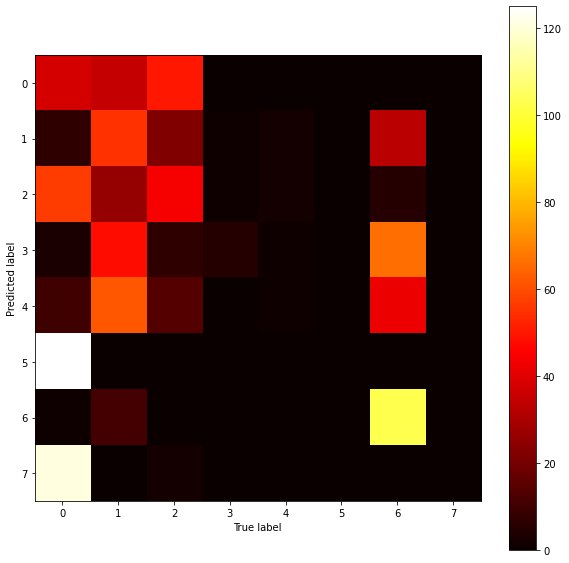

In [14]:
# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
plt.imshow(mat, cmap='hot', interpolation='nearest')

# Add some anotation for the plot
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()